# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, isnan
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline
sns.set(style="whitegrid")

In [2]:
# create a Spark session
spark = SparkSession.builder.appName('sparkify').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json('mini_sparkify_event_data.json')
df.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
print(f"Shape of original dataset: {df.toPandas().shape}")

Shape of original dataset: (286500, 18)


In [6]:
# let's find categorical and numerical features from the dataset
categorical_columns = list()
numerical_columns = list()

for i in range(len(df.dtypes)):
    if df.dtypes[i][1] == 'string':
        categorical_columns.append(df.dtypes[i][0])
    else:
        numerical_columns.append(df.dtypes[i][0])

print(f"Categorical columns: {categorical_columns}\n")
print(f"Numerical columns: {numerical_columns}")

Categorical columns: ['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']

Numerical columns: ['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']


#### Let's check unique values for the following categorical features:
- auth
- gender
- level
- method 
- page

In [7]:
df.select("auth").dropDuplicates().sort("auth").show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [8]:
df.select("gender").dropDuplicates().sort("gender").show()

+------+
|gender|
+------+
|  null|
|     F|
|     M|
+------+



In [9]:
df.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [10]:
df.select("method").dropDuplicates().sort("method").show()

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



In [11]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



**Observations:**
- 'auth' has cancelled status. This can be used to find churn rate.
- 'gender' column has null values. 
- 'level' and 'page' seem to be useful features. Let's analyse these further. 
- 'method' doesn't seem to be a useful feature for predictive modelling. So, we'll not consider 'method' for prediction.

In [12]:
unique_locations = df.select("location").dropDuplicates().count()
print(f"Number of unique locations :{unique_locations}")

Number of unique locations :115


In [13]:
unique_users = df.select(['userId']).dropDuplicates().count()
print(f"Number of unique users: {unique_users}")

Number of unique users: 226


In [14]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



**Observation:** 
- There are records in which userId is empty string. Let's get rid of this while removing null values.

In [15]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



**Observation:**
- There are 286500 records and 'sessionId' range is between 1 an 2474.

## Clean Data

In [16]:
def show_missing_count(df):
    """
    Summary: utility function to print missing values for each column in a dataframe

    Parameters:
      df: the dataframe to be used

    Returns:
      None
    """
    print("Missing values count for each column:")
    for column in df.columns:
        missing_count = df.filter((df[column] == "") | df[column].isNull() | isnan(df[column])).count()
        print('Column {}: '.format(column), missing_count)

In [17]:
show_missing_count(df)

Missing values count for each column:
Column artist:  58392
Column auth:  0
Column firstName:  8346
Column gender:  8346
Column itemInSession:  0
Column lastName:  8346
Column length:  58392
Column level:  0
Column location:  8346
Column method:  0
Column page:  0
Column registration:  8346
Column sessionId:  0
Column song:  58392
Column status:  0
Column ts:  0
Column userAgent:  8346
Column userId:  8346


**Observations:**
- There are 8346 missing values for 'userId' and other related columns (firstname, lastname, location, registration and userAgent) These records should be dropped. 
- There are also 58392 missing values for artist, length and song. These can be accepted as not all transactions are for playing songs on the app. 

In [18]:
def drop_null_values(df):
    """
    Summary: utility function to remove null values

    Parameters:
      df: the dataframe to be cleaned

    Returns:
      df_clean: the output dataframe without null values
    """
    df_clean = df.filter((df['userId'] != "") & df['userId'].isNotNull() & ~isnan(df['userId']))
    return df_clean

In [19]:
df_cleaned = drop_null_values(df)

In [20]:
show_missing_count(df_cleaned)

Missing values count for each column:
Column artist:  50046
Column auth:  0
Column firstName:  0
Column gender:  0
Column itemInSession:  0
Column lastName:  0
Column length:  50046
Column level:  0
Column location:  0
Column method:  0
Column page:  0
Column registration:  0
Column sessionId:  0
Column song:  50046
Column status:  0
Column ts:  0
Column userAgent:  0
Column userId:  0


In [21]:
def format_timestamp():
    """
    Summary: utility function format timestamp in YYYY-mm-dd H:M:S format

    Returns:
      df_cleaned: the output dataframe with formatted timestamp
    """
    global df_cleaned
    # create a user defined function for formating the timestamp
    get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    #apply the udf on the 'ts' column
    df_cleaned = df_cleaned.withColumn("time", get_time(df_cleaned.ts))
    return df_cleaned

In [22]:
df_cleaned = format_timestamp()

In [23]:
df_cleaned.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,time
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16


In [24]:
print(f"Shape of cleaned dataframe: {df_cleaned.toPandas().shape}")

Shape of cleaned dataframe: (278154, 19)


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


We'll explore cleaned data using spark sql. Let's create a temporary view to perform SQL operations.

In [25]:
# temporary view
df_cleaned.createOrReplaceTempView("sparkify_cleaned_data")

In [26]:
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_count
        FROM sparkify_cleaned_data
        GROUP BY gender
        ORDER BY user_count DESC
''')
gender_count.show()

+------+----------+
|gender|user_count|
+------+----------+
|     M|       121|
|     F|       104|
+------+----------+



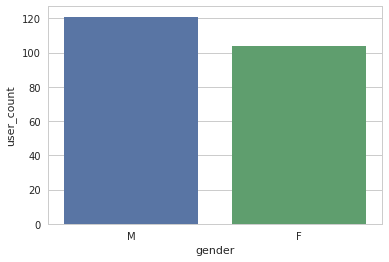

In [27]:
# analyse gender column using barplot
sns.barplot(x='gender',y='user_count',data=gender_count.toPandas())

**Observation:** 
- There are 121 males and 104 females. I we see barplot, the proportion is almost balanced.

In [28]:
spark.sql('''
        SELECT page,COUNT(userId) AS user_count
        FROM sparkify_cleaned_data
        GROUP BY page
        ORDER BY user_count DESC
''').show()

+--------------------+----------+
|                page|user_count|
+--------------------+----------+
|            NextSong|    228108|
|           Thumbs Up|     12551|
|                Home|     10082|
|     Add to Playlist|      6526|
|          Add Friend|      4277|
|         Roll Advert|      3933|
|              Logout|      3226|
|         Thumbs Down|      2546|
|           Downgrade|      2055|
|            Settings|      1514|
|                Help|      1454|
|             Upgrade|       499|
|               About|       495|
|       Save Settings|       310|
|               Error|       252|
|      Submit Upgrade|       159|
|    Submit Downgrade|        63|
|              Cancel|        52|
|Cancellation Conf...|        52|
+--------------------+----------+



Let's find ratio of different actions under page column.

In [29]:
print('Ratio of actions under page:')
action_list = df_cleaned.select("page").dropDuplicates().sort("page").collect()
for i in range(len(action_list)):
    action_name = action_list[i].__getitem__(0)
    action_count = df_cleaned.where(df_cleaned["page"]==action_name).count()/df_cleaned.count()*100
    print('Column {}: '.format(action_name), action_count)

Ratio of actions under page:
Column About:  0.177958972367825
Column Add Friend:  1.5376374238731063
Column Add to Playlist:  2.3461823306513656
Column Cancel:  0.01869467992550889
Column Cancellation Confirmation:  0.01869467992550889
Column Downgrade:  0.7387993701330917
Column Error:  0.09059729502362
Column Help:  0.5227320117632679
Column Home:  3.6246108270957818
Column Logout:  1.1597891815325323
Column NextSong:  82.00780862399965
Column Roll Advert:  1.4139649259043552
Column Save Settings:  0.11144905340207223
Column Settings:  0.5443027962927012
Column Submit Downgrade:  0.022649323755905
Column Submit Upgrade:  0.057162579002998336
Column Thumbs Down:  0.9153202901989544
Column Thumbs Up:  4.512248610481963
Column Upgrade:  0.17939702466978724


In [30]:
df_cleaned.select("page").where((df_cleaned["artist"].isNotNull())).dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



In [31]:
spark.sql('''
        SELECT DISTINCT(auth)
        FROM sparkify_cleaned_data
''').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [32]:
spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS user_count
        FROM sparkify_cleaned_data
        GROUP BY auth
        ORDER BY user_count DESC
''').show()

+---------+----------+
|     auth|user_count|
+---------+----------+
|Logged In|       225|
|Cancelled|        52|
+---------+----------+



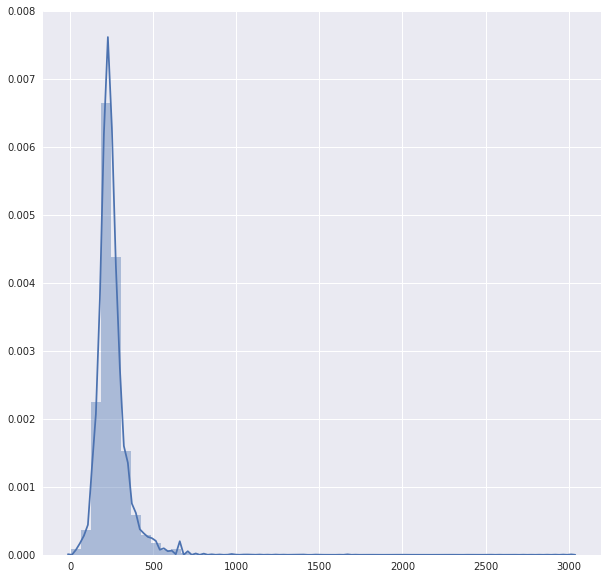

In [33]:
length_data = spark.sql('''
        SELECT length
        FROM sparkify_cleaned_data
''')
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(length_data.toPandas().dropna());

Observation: The feature 'length' is normally distributed around its mean. The above distribution plot shows that length range is 0-500 seconds.

In [34]:
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_count
        FROM sparkify_cleaned_data
        GROUP BY level
        ORDER BY user_count DESC
''').show()

+-----+----------+
|level|user_count|
+-----+----------+
| free|       195|
| paid|       165|
+-----+----------+



**Observations:**
- It seems that majority of the dataset is composed of the action "NextSong" i.e ~ 82%. And the columns Artist and Song are filled only when the value in the page column is "NextSong". And remaining 18% i.e 50046 rows are under pages other than "NextSong".

- Prior to remove null values, we had two more values for 'auth' feature wise. 'Guest' and 'Logged out'. It clearly states that those values are associated with unknown userids and therefore we do not have any row with this auth values in the cleaned dataset.

- There are 52 users who have Cancelled the sparkify subscription.

- The feature 'length' is normally distributed around its mean. The above distribution plot shows that length range is 0-500 seconds.
- There are 195 free and 165 paid accounts in this dataset.

Let's explore 'location' column. We'll split location into 'city' and 'state' and then visualize distribution among cities and states.

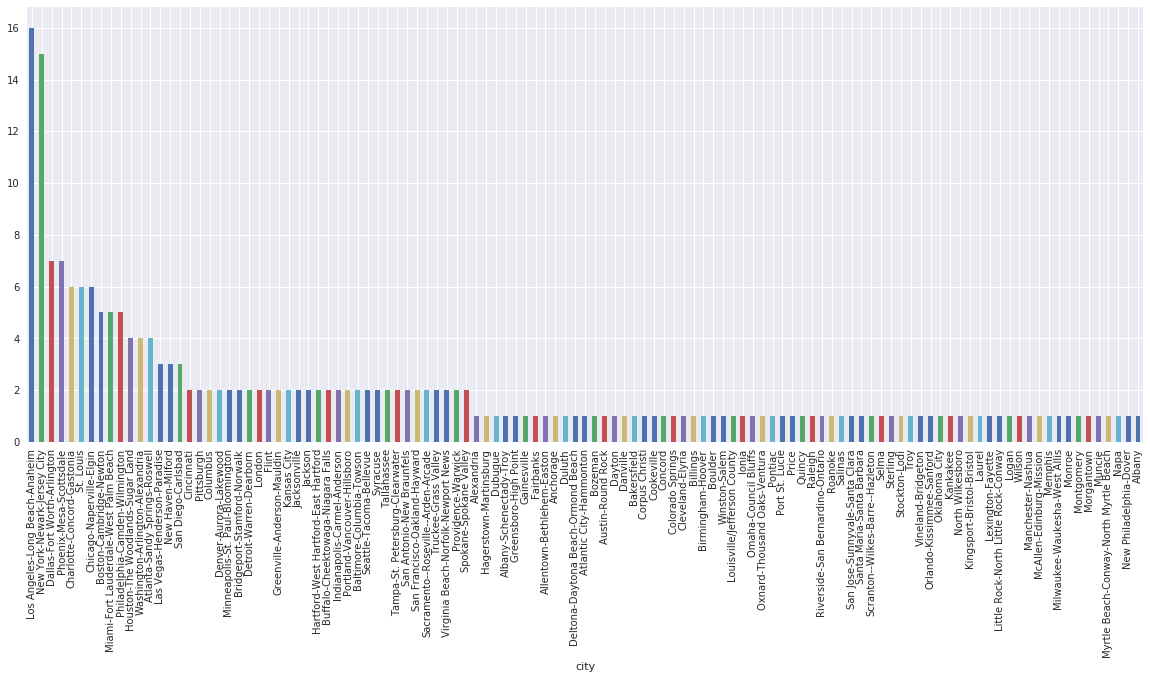

In [35]:
location_count = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_count
        FROM sparkify_cleaned_data
        GROUP BY location
        ORDER BY user_count DESC
''').toPandas()
location_count = location_count.join(location_count['location'].str.split(',',expand=True).rename(columns={0:'city',1:'state'})).drop('location',axis=1)
location_count.groupby('city')['user_count'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(20,8))

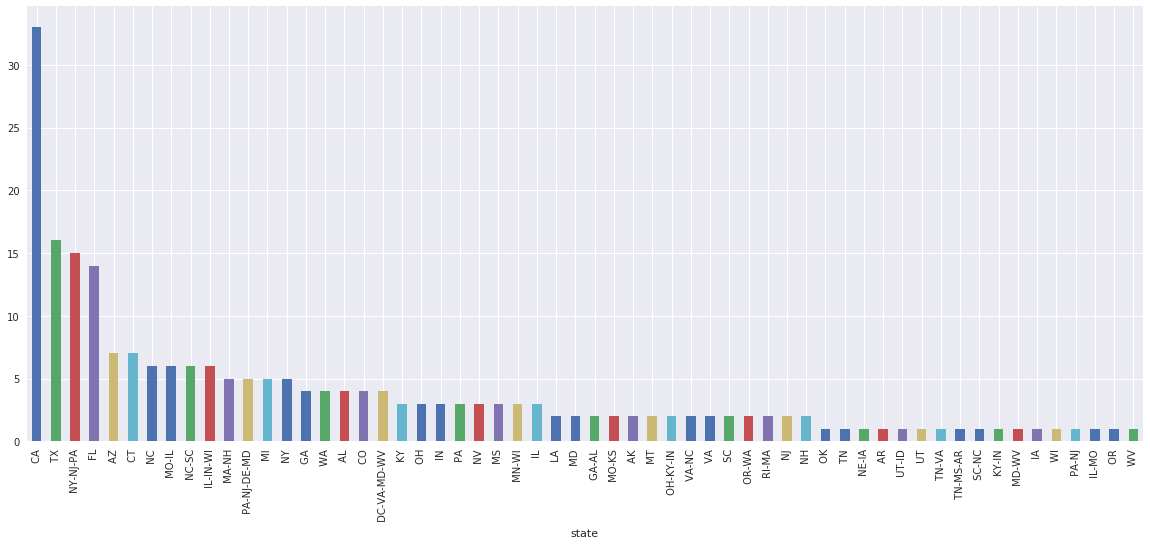

In [36]:
location_count.groupby('state')['user_count'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(20,8))

**Observation:** 
- Majority of user count is from cities CA, TX, NY-NJ-PA and FL. California is the state having the most user count.

In [37]:
time_data = spark.sql('''
        SELECT time,userId
        FROM sparkify_cleaned_data
''').toPandas()

time_data['time'] = pd.to_datetime(time_data['time'])

weekday_dict = {0:'Mon.',1:'Tues.',2:'Wed.',3:'Thur.',4:'Fri.',5:'Sat.',6:'Sun.'}
time_data['weekday'] = time_data['time'].dt.weekday.map(weekday_dict)
time_data['day'] = time_data['time'].dt.day
time_data['hour'] = time_data['time'].dt.hour

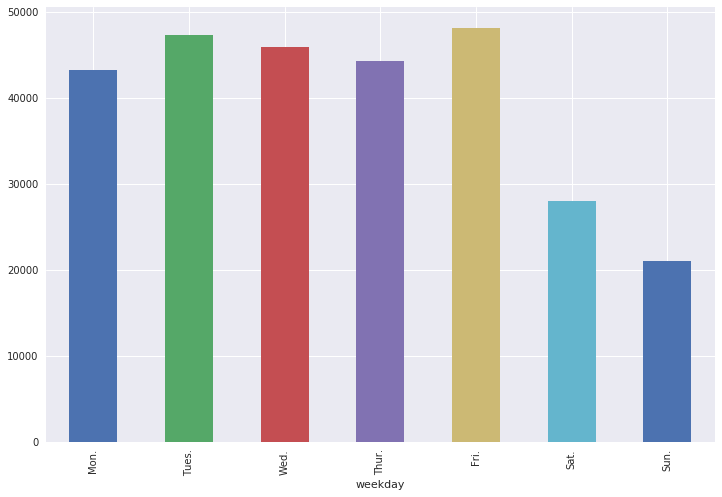

In [38]:
time_data.groupby('weekday')['userId'].count().loc[list(weekday_dict.values())].plot(kind='bar', figsize=(12, 8))

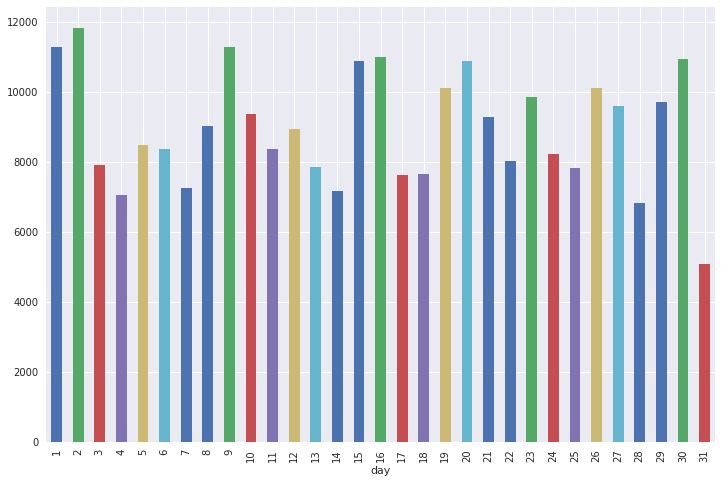

In [39]:
time_data.groupby('day')['userId'].count().plot(kind='bar', figsize=(12, 8))

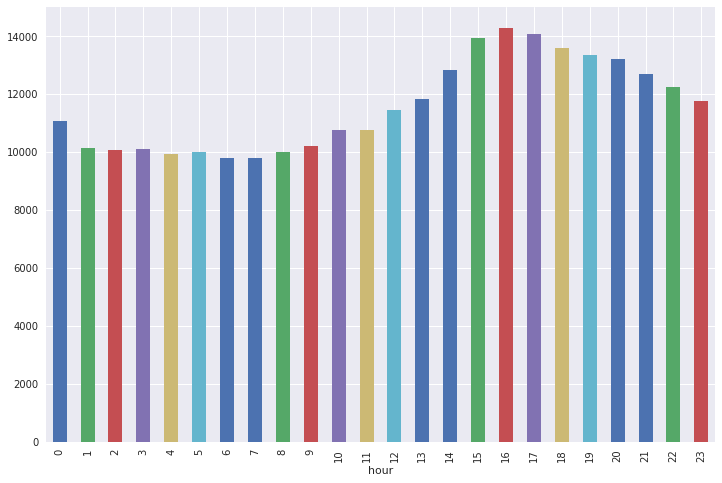

In [40]:
time_data.groupby('hour')['userId'].count().plot(kind='bar', figsize=(12, 8))

**Observation:** 
- User behavior is periodic. They use Sparkify more offten in workdays than weekend.


### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

First, we'll define a column named 'churn' as a label. 

Let's first confirm that 'Cancellation Confirmation' can really used to define churn.

In [41]:
df_cleaned.filter((df_cleaned['auth']=='Cancelled')&(df_cleaned['page']!='Cancellation Confirmation')).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|time|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+----+



**Observation:** 
- For every 'Cancellation Confirmation' page, we have auth value set to 'Cancelled'. We can use 'Cancellation Confirmation' page to define churn as we are sure that it indicates action of the user to cancel the service.

In [42]:
def create_churn_label():
    """
    Summary: utility function to create 'churn' label

    Returns:
      df_cleaned_cancel: the output dataframe with 'churn' column
    """
    global df_cleaned
    # let's define the flag event using  udf(user defined function) to transform event to 0 or 1
    flag_event = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())
    # create 'churn_state' column
    df_cleaned_cancel = df_cleaned.withColumn('churn_state',flag_event('page'))
    # let's mark the users who have churned event
    userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
    df_cleaned_cancel = df_cleaned_cancel.withColumn('churn',fmax('churn_state').over(userwindow))
    return df_cleaned_cancel

In [43]:
df_cleaned_cancel= create_churn_label()

In [44]:
df_cleaned_cancel.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,ts,userAgent,userId,time,churn_state,churn
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,2018-10-08 12:58:54,0,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,2018-10-08 13:02:16,0,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,2018-10-08 13:05:32,0,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,2018-10-08 13:05:33,0,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1538016340000,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,2018-10-08 13:09:55,0,0


In [45]:
df_cleaned_cancel.dropDuplicates(['userId']).select('churn').groupby('churn').count().collect()

[Row(churn=1, count=52), Row(churn=0, count=173)]

**Observation:** 
- 52 users have churned events in the dataset. It's about 23.1 percent churned rate. And the data seems to be unbalanced within two categories i.e churn event and not churn event. 

Now, let's check the count of values of some fetaures for above defined churn dataframe.

In [46]:
df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["churn", "auth"]).count().sort("churn").show()

+-----+---------+-----+
|churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  173|
|    1|Logged In|   52|
+-----+---------+-----+



**Observation:** 
- It seems that 'auth' has no effect on churn.

In [47]:
 df_cleaned_cancel.select(["churn", "length"]).groupby(["churn"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                    fmax('length').alias('max_length'),
                                                                    fmin('length').alias('min_length')).show()

+-----+------------------+------------------+----------+----------+
|churn|       mean_length|      stdev_length|max_length|min_length|
+-----+------------------+------------------+----------+----------+
|    1|248.63279564406218|102.38497717575477|3024.66567|   4.04853|
|    0|249.20913538880816|  98.6258830014688|3024.66567|   0.78322|
+-----+------------------+------------------+----------+----------+



In [48]:
df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["churn", "level"]).count().sort("churn").show()

+-----+-----+-----+
|churn|level|count|
+-----+-----+-----+
|    0| free|  133|
|    0| paid|   40|
|    1| paid|    8|
|    1| free|   44|
+-----+-----+-----+



**Observation:**
- We should consider 'level' as a value addition feature as level count seems different for each churn label.

In [49]:
def normalize_data(data):
    """
    Summary: Utility function to normalize the given set of data

    Parameters:
      data: dataframe

    Returns:
      df: dataframe containing normalized data.
    """
    groupby_series = data.set_index(list(data.columns[:2]))
    temp = groupby_series.unstack('churn').fillna(0)
    df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
    df = df.rename(columns={df.columns[-1]:'normalized_result'})
    return df

Let's split location into city and state to separately normalize and visualize respective data w.r.t churn event.

In [50]:
split_city_state = split(df_cleaned_cancel['location'], ',')
df_cleaned_cancel = df_cleaned_cancel.withColumn('city',split_city_state.getItem(0))
df_cleaned_cancel = df_cleaned_cancel.withColumn('state',split_city_state.getItem(1))

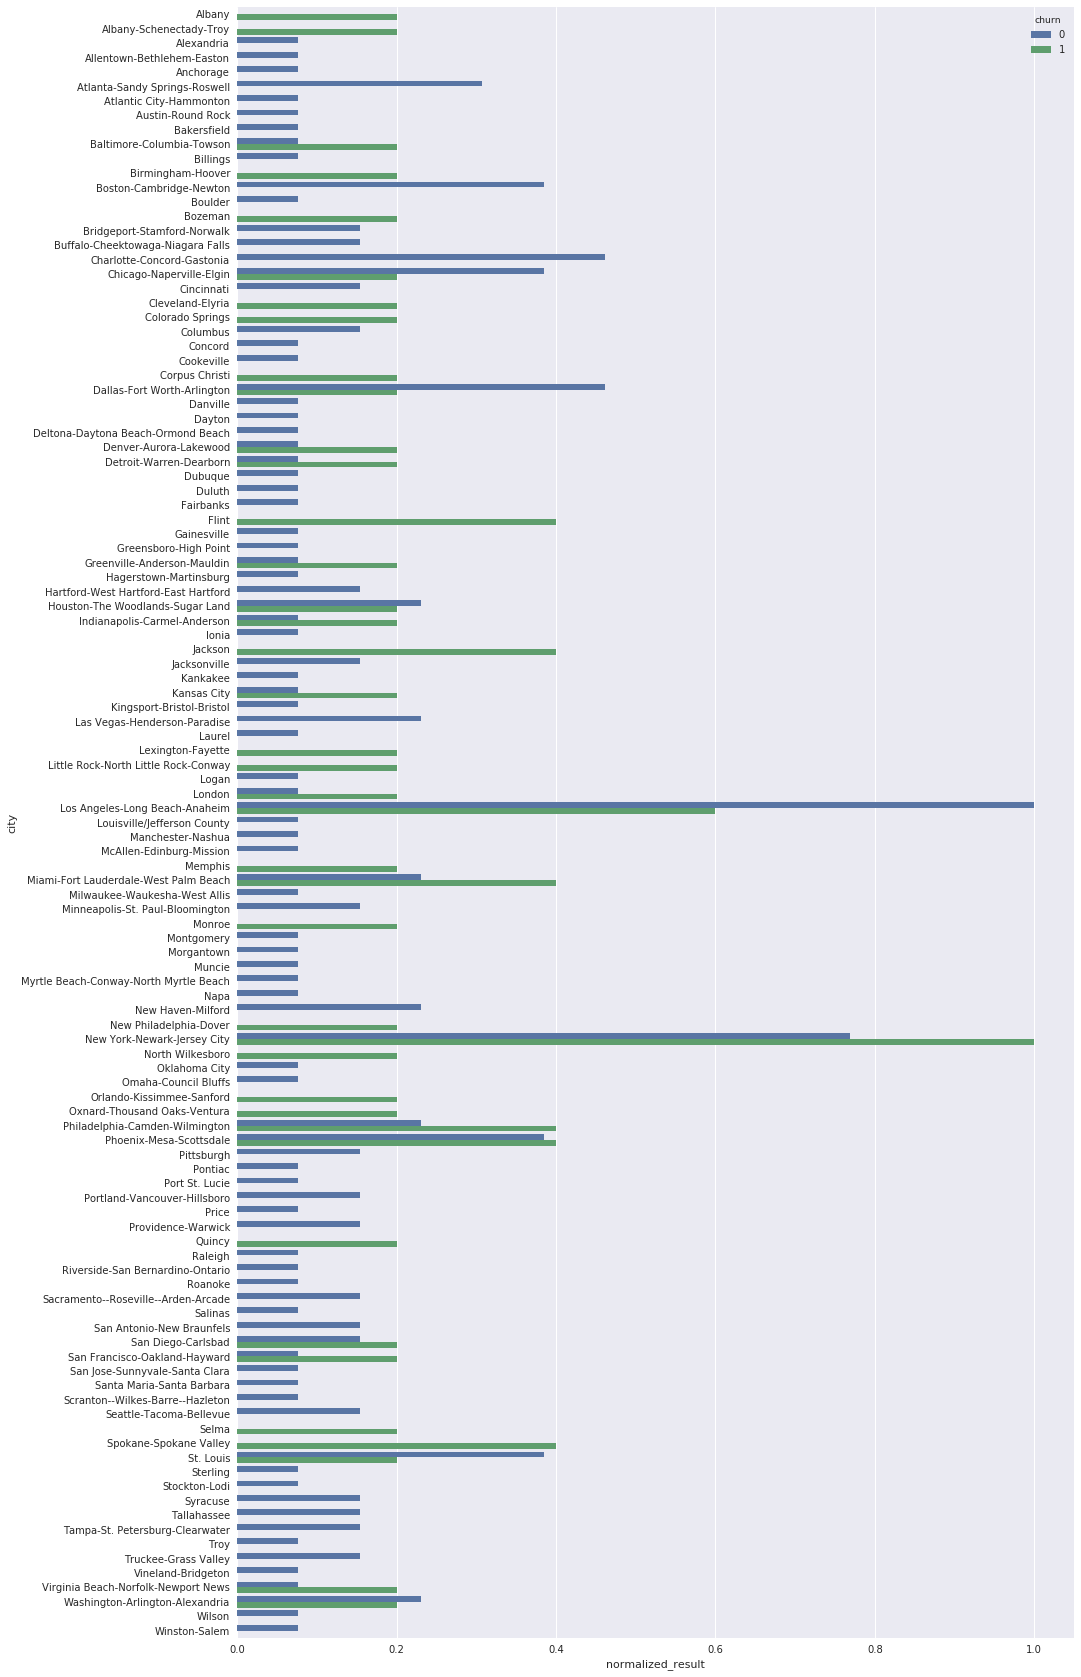

In [51]:
city_data = df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["city","churn"]).count().sort("city").toPandas()
city_data = normalize_data(city_data)
fig, ax = plt.subplots(figsize=(15,30))
sns.barplot( x="normalized_result",y="city", hue="churn", data=city_data);

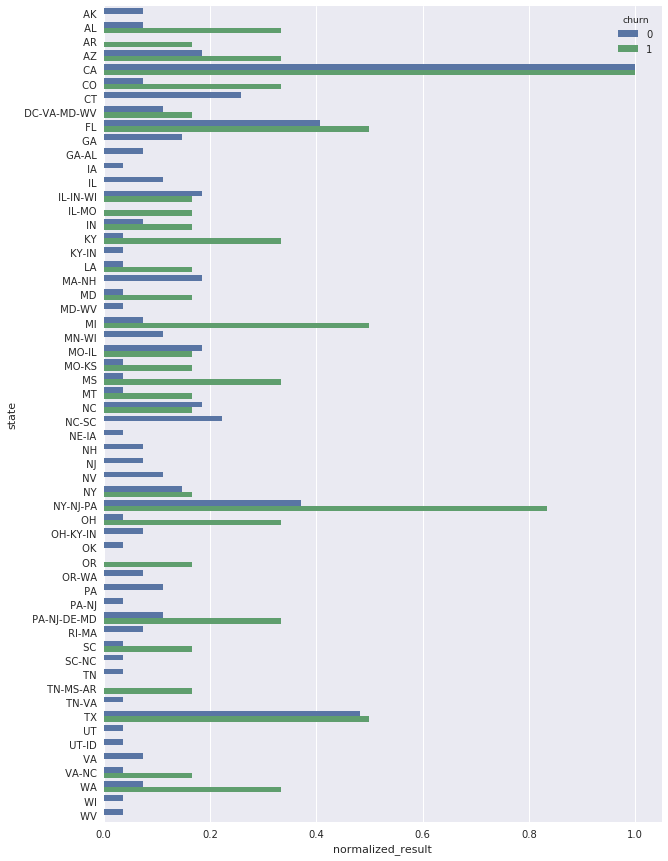

In [52]:
state_data = df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["state","churn"]).count().sort("state").toPandas()
state_data = normalize_data(state_data)
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot( x="normalized_result",y="state", hue="churn", data=state_data,ax=ax)

In [53]:
df_cleaned_cancel.select(["churn", "page"]).groupby(["churn", "page"]).count().sort("page").show()

+-----+--------------------+------+
|churn|                page| count|
+-----+--------------------+------+
|    1|               About|    56|
|    0|               About|   439|
|    1|          Add Friend|   636|
|    0|          Add Friend|  3641|
|    1|     Add to Playlist|  1038|
|    0|     Add to Playlist|  5488|
|    1|              Cancel|    52|
|    1|Cancellation Conf...|    52|
|    0|           Downgrade|  1718|
|    1|           Downgrade|   337|
|    0|               Error|   220|
|    1|               Error|    32|
|    0|                Help|  1215|
|    1|                Help|   239|
|    0|                Home|  8410|
|    1|                Home|  1672|
|    1|              Logout|   553|
|    0|              Logout|  2673|
|    1|            NextSong| 36394|
|    0|            NextSong|191714|
+-----+--------------------+------+
only showing top 20 rows



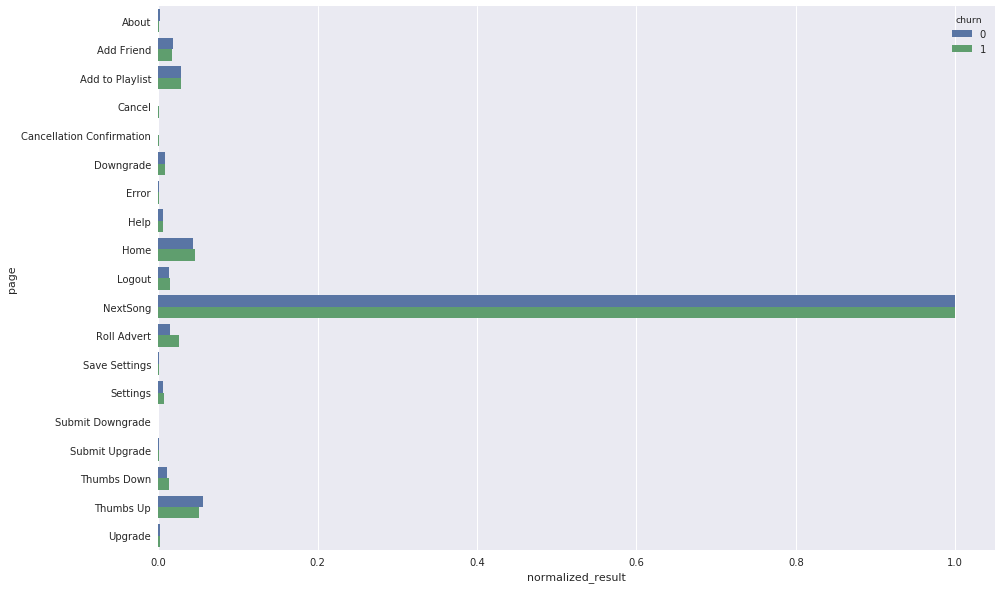

In [54]:
page_data = df_cleaned_cancel.select(["page","churn"]).groupby([ "page","churn"]).count().sort("page").toPandas()
page_data = normalize_data(page_data)
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot( x="normalized_result",y="page", hue="churn", data=page_data,ax=ax);

**Observation:** 
- Page NextSong,Thumbs Up/Down, Home, Add to Playlist seems have effect on churn.

In [55]:
# create 'hour' column in cleaned dataframe using 'ts'
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_cleaned_cancel = df_cleaned_cancel.withColumn('hour', get_hour(df_cleaned_cancel.ts))

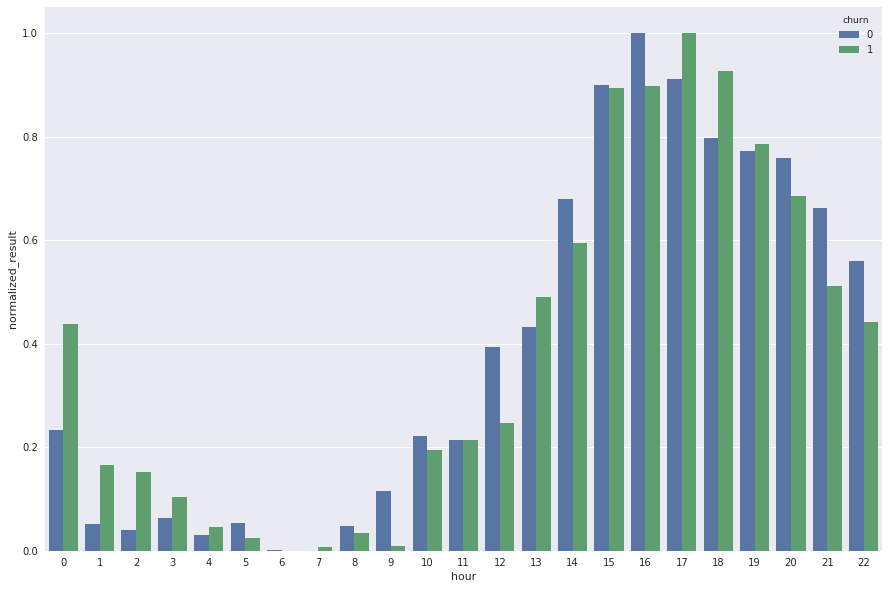

In [56]:
# normalize and visualise hour data w.r.t churn column
hour_data = df_cleaned_cancel.select(["churn", "hour"]).groupby(["churn", "hour"]).count().sort("hour").toPandas()
hour_data = normalize_data(hour_data)
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot( x="hour",y="normalized_result", hue="churn", data=hour_data,ax=ax,order=list(map(lambda x: str(x),range(23))));

In [57]:
# create 'day' column in cleaned dataframe using 'ts'
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_cleaned_cancel = df_cleaned_cancel.withColumn('day', get_day(df_cleaned_cancel.ts))

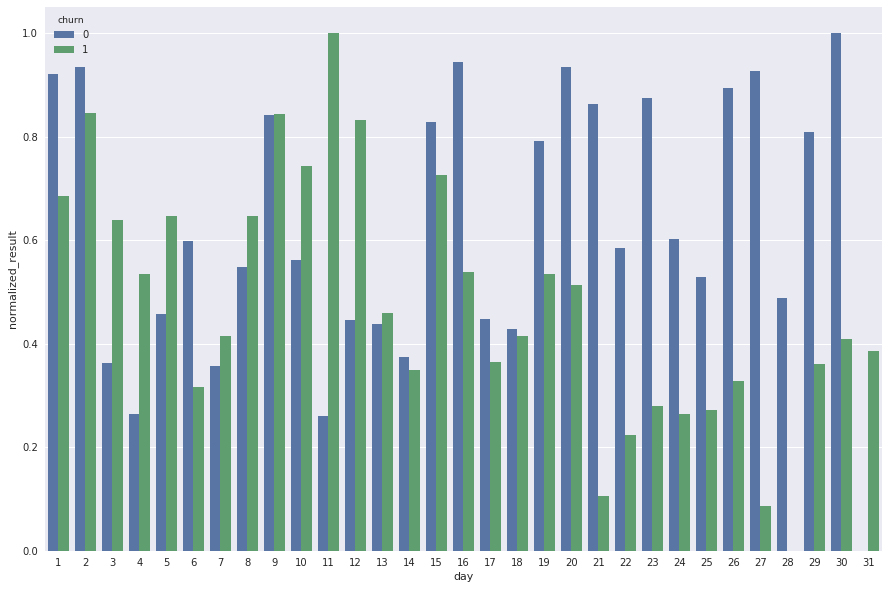

In [58]:
# normalize and visualise day data w.r.t churn column
day_data = df_cleaned_cancel.select(["churn", "day"]).groupby(["churn", "day"]).count().sort("day").toPandas()
day_data = normalize_data(day_data)
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot( x="day",y="normalized_result", hue="churn", data=day_data,ax=ax,order=list(map(lambda x: str(x),range(1,32))));

In [59]:
# create 'dayofweek' column in cleaned dataframe using 'ts'
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))
df_cleaned_cancel = df_cleaned_cancel.withColumn('dayofweek', get_weekday(df_cleaned_cancel.ts))

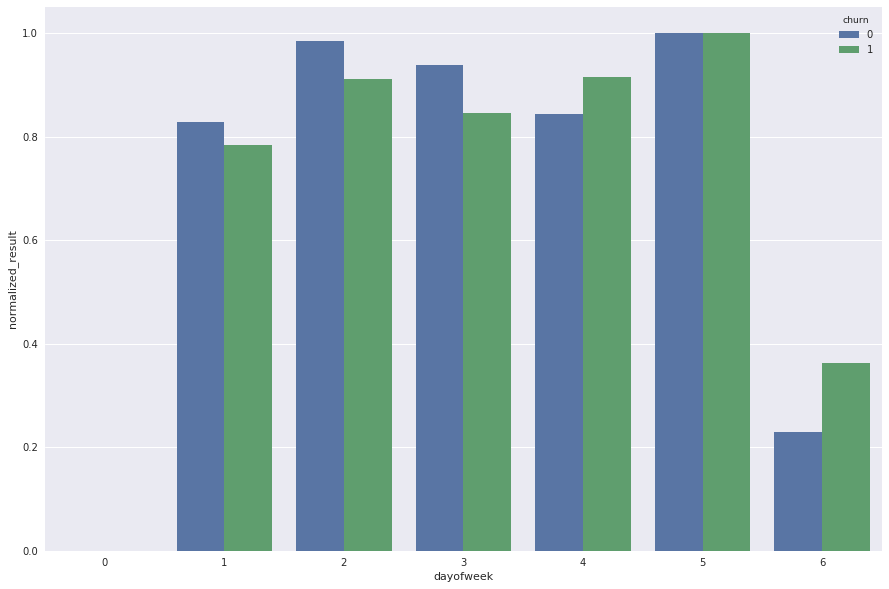

In [60]:
# normalize and visualise dayofweek data w.r.t churn column
dayofweek_data = df_cleaned_cancel.select(["churn", "dayofweek"]).groupby(["churn", "dayofweek"]).count().sort("dayofweek").toPandas()
dayofweek_data = normalize_data(dayofweek_data)
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot( x="dayofweek",y="normalized_result", hue="churn", data=dayofweek_data,ax=ax);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [61]:
df_cleaned_cancel.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churn_state: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- day: string (nullable = true)
 |-- dayofweek: string (nullable = true)



Now we'll create new features based on our exploratory data analysis. Those will be derived features for performing predictive modelling. We'll only consider categorical features which add value to our predictive model and discard remaining columns.

- Categorical Features to be considered
    - gender
    - level
    
- Derived Numerical Features
    - average item length (mean_length)
    - numbers of following items under page 
        - NextSong
        - ThumbsUp
        - ThumbsDown
        - AddtoPlaylist 
        - AddFriend
        - RollAdvert
    - number of unique songs of users
    - number of total songs of users
    - number of unique artists of users
    - percentage of operations after 15th in a month
    - percentage of operations in workday

In [62]:
def label_encode_categorical_feature(column_name):
    temp_df = df_cleaned_cancel.select([column_name]).dropDuplicates().toPandas()
    label_dict = {val:str(idx) for idx, val in enumerate(temp_df[column_name].tolist())}
    result = df_cleaned_cancel.dropDuplicates(['userId']).select(['userId',column_name]).replace(label_dict,subset=column_name)
    return result

In [63]:
def get_combined_encoded_categorical_features():
    feature_gender = label_encode_categorical_feature('gender')
    feature_level = label_encode_categorical_feature('level')
    result = feature_gender.join(feature_level,on='userId',how='inner')
    return result

In [64]:
categorical_features = get_combined_encoded_categorical_features()
categorical_features.toPandas().head(10)

,userId,gender,level
0,100010,0,0
1,200002,1,0
2,125,1,0
3,124,0,1
4,51,1,1
5,7,1,0
6,15,1,1
7,54,0,1
8,155,0,0
9,100014,1,1


In [65]:
def get_derived_numerical_features():
    """
    Summary: utility function to derive numerical feature based on exploratory data analysis
    """
    # calculate average length 
    feature_length = df_cleaned_cancel.groupBy('userId').avg('length').withColumnRenamed('mean_length', 'length')
    
    page_count = df_cleaned_cancel.select(["userId","page"]).groupby(["userId","page"]).count()
    
    temp1 = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)
    
    temp1 = temp1.select(['userId','NextSong','Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Roll Advert'])
    
    cols = temp1.columns[1:]
    
    # feature page as defined in above description
    feature_page = temp1.withColumn('total', sum([col(c) for c in cols]))    
    
    # number of unique songs
    feature_nunique_song = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","song"]).\
                                             dropDuplicates(["userId","song"]).groupby(["userId"]).count()
    feature_nunique_song = feature_nunique_song.selectExpr("userId as userId","count as nunique_song")
    
    # number of total songs
    feature_ntotal_song = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","song"]).\
                                             groupby(["userId"]).count()
    feature_ntotal_song = feature_ntotal_song.selectExpr("userId as userId","count as ntotal_song")
    
    # number of unique artists
    feature_nunique_artist = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","artist"]).\
                                               dropDuplicates(["userId","artist"]).groupby(["userId"]).count()
    feature_nunique_artist = feature_nunique_artist.selectExpr("userId as userId","count as nunique_artist")
    
    day_count = df_cleaned_cancel.filter(df_cleaned_cancel.day>=15).select(['userId']).groupby(["userId"]).count()
    day_count = day_count.selectExpr("userId as userId","count as day_count")
    
    total_count = df_cleaned_cancel.select(['userId']).groupby(["userId"]).count()
    total_count = total_count.selectExpr("userId as userId","count as total_count")
    
    dayofweek_count = df_cleaned_cancel.filter(df_cleaned_cancel.dayofweek<5).select(['userId']).groupby(["userId"]).count()
    dayofweek_count = dayofweek_count.selectExpr("userId as userId","count as dayofweek_count")
    
    # percentage of operations after 15th in a month
    feature_percentage_month = (total_count.alias("total").join(day_count.alias("day"), ["userId"]).\
                              select(col("userId"), (col("day.day_count") / col("total.total_count")).alias("month_percentage")))
    # percentage of operations in workday
    feature_percentage_week = (total_count.alias("total").join(dayofweek_count.alias("day"), ["userId"]).\
                          select(col("userId"), (col("day.dayofweek_count") / col("total.total_count")).alias("week_percentage")))
    
    result = feature_length.join(feature_page,on='userId',how='inner').\
                        join(feature_nunique_song,on='userId',how='inner').\
                        join(feature_ntotal_song,on='userId',how='inner').\
                        join(feature_nunique_artist,on='userId',how='inner').\
                        join(feature_percentage_month,on='userId',how='inner').\
                        join(feature_percentage_week,on='userId',how='inner')
    
    return result

In [66]:
def prepare_training_data():
    """
    Summary: utility function to prepare training churn features and labels for predictive modelling
    """
    categorical_feature = get_combined_encoded_categorical_features()
    numerical_feature = get_derived_numerical_features()
    label = df_cleaned_cancel.select(['userId','churn']).dropDuplicates()
    result = categorical_feature.join(numerical_feature,on='userId',how='inner').join(label,on='userId',how='inner') 
    # correct the datatypes of derived features
    for col_name in result.columns[1:5]:
        result = result.withColumn(col_name, result[col_name].cast(IntegerType()))
    for col_name in result.columns[5:-1]:
        result = result.withColumn(col_name, result[col_name].cast(FloatType()))
    #fill NaN
    result = result.na.fill(0)
    return result

In [67]:
training_data = prepare_training_data() 
# create a local copy of generated training data (save data in a JSON file)
# training_data.write.save('training_data.json',format='json',header=True)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


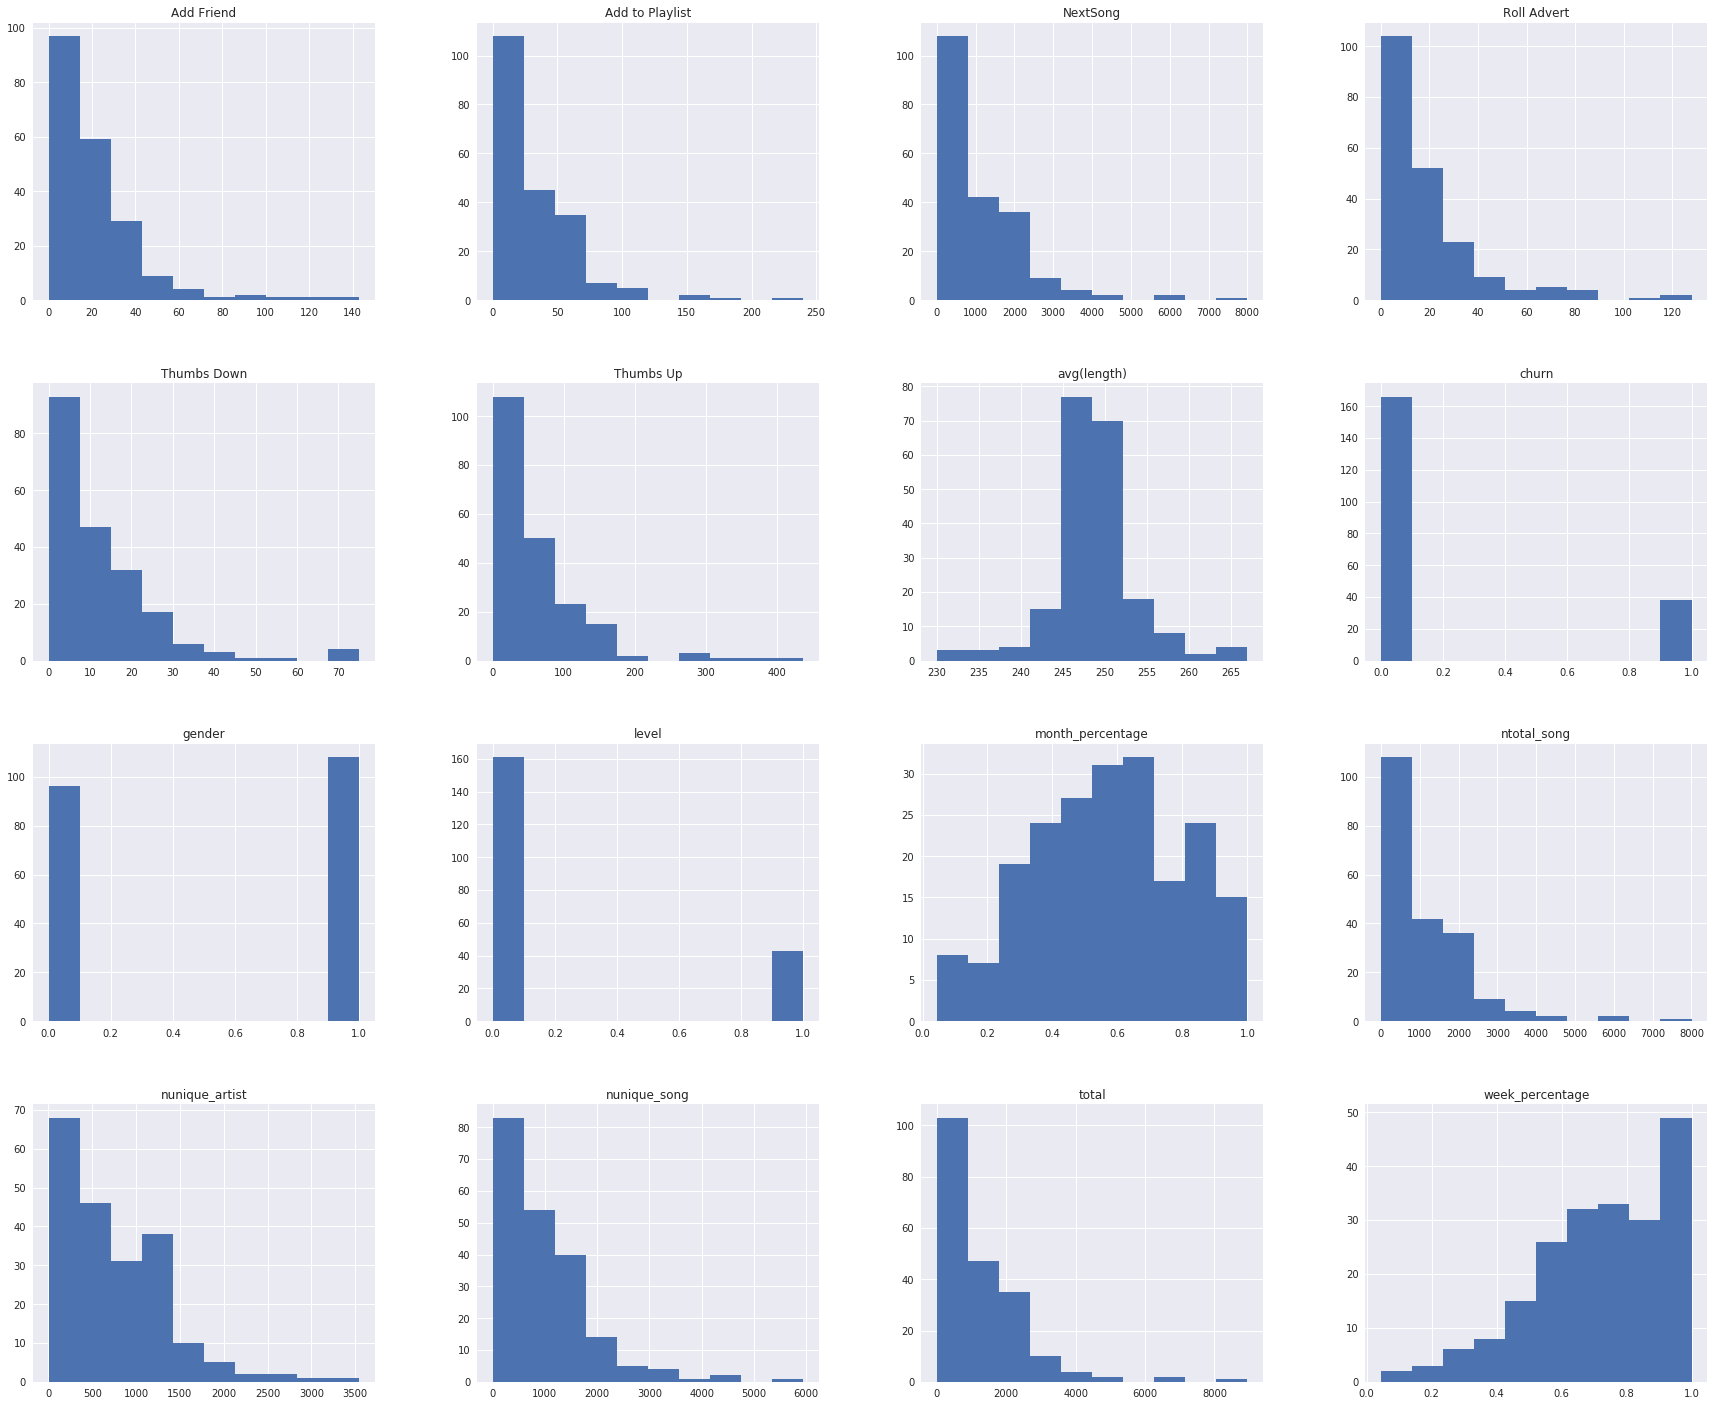

In [68]:
fig = plt.figure(figsize=(30,25))
ax = fig.gca()
h = training_data.toPandas().hist(ax=ax)

**Observation:**
- In above histograms, we can see that most of the features are skewed. Normalization is required. We can do it with the help of standard scaler.

In [69]:
training_data_columns = training_data.columns
training_data_columns.remove('churn')
training_data_columns.remove('userId')
categorical_features = ['gender','level']
numerical_features = [column_name for column_name in training_data_columns if column_name not in categorical_features]

In [70]:
training_data_df = training_data.toPandas()

In [71]:
training_data_df.head()

,userId,gender,level,avg(length),NextSong,Thumbs Up,Thumbs Down,Add to Playlist,Add Friend,Roll Advert,total,nunique_song,ntotal_song,nunique_artist,month_percentage,week_percentage,churn
0,100010,0,0,243,275,17.0,5.0,7.0,4.0,52.0,360.0,269.0,275.0,252.0,0.412073,0.548556,0
1,200002,1,0,242,387,21.0,6.0,8.0,4.0,7.0,433.0,378.0,387.0,339.0,0.921941,1.000000,0
2,124,0,1,248,4079,171.0,41.0,118.0,74.0,4.0,4487.0,3339.0,4079.0,2232.0,0.457824,0.739896,0
3,51,1,1,247,2111,100.0,21.0,52.0,28.0,0.0,2312.0,1854.0,2111.0,1385.0,0.167208,0.719156,1
4,7,1,0,253,150,7.0,1.0,5.0,1.0,16.0,180.0,148.0,150.0,142.0,0.741294,0.815920,0


In [72]:
training_data_df.shape

(204, 17)

In [73]:
def apply_std_scaler(training_data, num_features):
    """
    Summary: Utility function to scale numerical feature using standardscalar 

    Parameters:
      training_data: training data to be scaled

    Returns:
      result_scaled: dataframe containing scaled numerical features
    """
    
    # apply standardscaler on the numerical features
    vector = VectorAssembler(inputCols=num_features, outputCol='numerical_features')
    temp = vector.transform(training_data)
    scaler = StandardScaler(withMean=True, withStd=True, inputCol='numerical_features', outputCol='features_scaled')
    scaler_fit = scaler.fit(temp)
    result_scaled = scaler_fit.transform(temp)
    return result_scaled

In [74]:
scaled_data = apply_std_scaler(training_data, numerical_features)

In [75]:
# add categorical features to feature vector
vector = VectorAssembler(inputCols=categorical_features+['features_scaled'], outputCol='all_features')
result_scaled = vector.transform(scaled_data)
resultant_data = result_scaled.select(result_scaled.churn.alias('label'), result_scaled.all_features.alias('features'))

In [76]:
resultant_data.toPandas().head()

,label,features
0,0,"[0.0, 0.0, -1.06966981473, -0.733173309889, -0..."
1,0,"[1.0, 0.0, -1.26209718881, -0.633512756456, -0..."
2,0,"[0.0, 1.0, -0.107532944338, 2.65172620135, 1.6..."
3,1,"[1.0, 1.0, -0.299960318418, 0.900547905316, 0...."
4,0,"[1.0, 0.0, 0.854603926057, -0.844401606131, -0..."


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

As we can see, the dataset is very unbalanced with much more 0 than 1 in the target variable (churn). Since some algorithms can not deal with unbalanced data well, so we choose to undersample the majority class(0).

In [77]:
def majority_undersample(df):
    """
    Summary: utility function undersample the majority class(1)

    Parameters:
      df: the dataframe to be used

    Returns:
      result: resampled dataframe with equal number of for both churn labels(0 and 1)
    """
    minority_class_size = df.where(df.label == '1').count()
    df_minority = df.where(df.label == '1')
    df_majority = df.where(df.label == '0').sample(1.0, seed=7).limit(minority_class_size)
    result = df_minority.union(df_majority)
    result = result.orderBy(rand())
    return result

In [78]:
balanced_data = majority_undersample(resultant_data)
balanced_data.toPandas().head()

,label,features
0,0,"[0.0, 0.0, -0.492387692497, 2.20147405817, 1.5..."
1,1,"[0.0, 0.0, -0.299960318418, -0.206396098886, -..."
2,1,"[0.0, 1.0, -0.299960318418, -0.601479007138, -..."
3,1,"[1.0, 0.0, 1.04703130014, -0.651309283855, -0...."
4,1,"[1.0, 0.0, 0.0848944297408, 0.621142425156, 0...."


In [79]:
balanced_data.groupby(balanced_data.label).count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   38|
|    0|   38|
+-----+-----+



In [80]:
train, test = balanced_data.randomSplit([0.7, 0.3], seed=7)

In [81]:
print(f"Training Data Count :{train.count()}\nTest Data Count :{test.count()}")

Training Data Count :56
Test Data Count :20


We'll use below 4 classification algorithms and choose the best performing model out of them. 
1. Logistic Regression
2. Decision Tree
3. Random Forest Classifier
4. LinearSVC

In [82]:
# let's initialize the classification models
logistic_clf = LogisticRegression(maxIter=50)
decision_tree_clf = DecisionTreeClassifier()
random_forest_clf = RandomForestClassifier()
svm_clf = LinearSVC() 

In [83]:
# let's define the evaluator
evaluator= MulticlassClassificationEvaluator(predictionCol="prediction")

In [84]:
def train_models():
    """
    Summary: utility function to train classification algorithms and get/save evaluation results
    Returns:
      evaluation_results_df: a dataframe containing evaluation results for trained algorithms
    """
    evaluation_results = {}
    for clf in [logistic_clf, decision_tree_clf, random_forest_clf]:
        model_results = {}
        clf_name = clf.__class__.__name__
        
        print(f"Training of {clf_name} is in progress ...")
        start_time = time.time() 
        model = clf.fit(train)
        end_time = time.time() 
        model_results['train_time'] = round(end_time - start_time,6)
        
        print(f"Predicting test data on {clf_name} is in progress ...")
        start_time = time.time() 
        pred_test = model.transform(test)
        end_time = time.time()
        model_results['pred_time'] = round(end_time - start_time,6)
        
        print(f"Evaluation of {clf_name} is in progress ...")    
        model_results['f1_test'] = evaluator.evaluate(pred_test.select('label','prediction'),{evaluator.metricName: 'f1'})
        print('Test F1-score: ',model_results['f1_test'])
        
        evaluation_results[clf_name] = model_results

    evaluation_results_df = pd.DataFrame(evaluation_results)
    evaluation_results_df.to_csv('model_evaluation_results.csv')
    return evaluation_results_df

In [17]:
train_models()

Training of LogisticRegression is in progress ...
Predicting test data on LogisticRegression is in progress ...
Evaluation of LogisticRegression is in progress ...
Test F1-score:  0.7125
Training of DecisionTreeClassifier is in progress ...
Predicting test data on DecisionTreeClassifier is in progress ...
Evaluation of DecisionTreeClassifier is in progress ...
Test F1-score:  0.6640000000000001
Training of RandomForestClassifier is in progress ...
Predicting test data on RandomForestClassifier is in progress ...
Evaluation of RandomForestClassifier is in progress ...
Test F1-score:  0.459649
Training of LinearSVC is in progress ...
Predicting test data on LinearSVC is in progress ...
Evaluation of LinearSVC is in progress ...
Test F1-score:  0.612121



,Unnamed: 0,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,LinearSVC
0,f1_test,0.712500,0.664000,0.459649,0.612121
1,pred_time,0.125920,0.089461,0.087427,0.093973
2,train_time,215.174206,160.513467,166.707532,2317.460366


**Observations:**
- From the evaluation results above, it seems that LogisticRegression model is outperforming than DecisionTreeClassifier, RandomForest and LinearSVC models.
- We got f1-score = 0.71 for logistic regression.
- We also got f1-score = 0.66 for decision tree and f1-score = 0.61 for LinearSVC.
- F1-score for RandomForestClassifier is below 50%. Hence, it doesn't seem to be useful for this data.
- We'll now pick logistic regression for further fine tuning. For this purpose, we'll use cross validation method using predefined grid of parameters. Let's define parameter grid and fit the logistic model into 3-fold cross-validation process.

In [20]:
# define parameter grid for Logistic Regression
logistic_paramGrid = ParamGridBuilder().\
            addGrid(logistic_clf.elasticNetParam,[0.1, 0.5, 1]).\
            addGrid(logistic_clf.regParam,[0.01, 0.05, 0.1]).\
            build()
# define cross-validator for lotgistic Regression
logistic_crossval = CrossValidator(estimator=logistic_clf,
                          estimatorParamMaps=logistic_paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                          numFolds=3)
# tune Logistic Regression
start_time = time.time()
lr_cv_model = logistic_crossval.fit(train)
avg_metrics = lr_cv_model.avgMetrics
end_time = time.time()
print(f'Model tuning took {} seconds.')

Model tuning took 4920.334519 seconds.


In [23]:
pred = lr_cv_model.transform(test)
print('Accuracy: {}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(pred.select('label','prediction'), {evaluator.metricName: "f1"})))

Accuracy: 0.701245192
F-1 Score:0.712500001


In [25]:
# save logistic regression model
# lr_cv_model.save('lr_model')
print("Model saved successfully!")

Model saved successfully!


## Conclusion


Logistic regression model has outperformed with f1 score around 71%. We have got these results on the tiny subset i.e 128 MB of data. It can definitely be experimented on the actual 12 GB of huge dataset with the help of AWS or IBM Watson's spark clusters. Our churn prediction model should help Sparkify to identify users for special promotions or other measures to prevent them from cancelling the service. However, the model should avoid falsely classifying loyal users as vulnerable to churn, because offering discounts or other promotions is expensive and should be targeted to users we would otherwise lose as customers.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.